In [115]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda
from torch import nn
import numpy
import matplotlib.pyplot as plt
import random

%matplotlib inline

# Checking for GPU

In [116]:
if torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Loading a Dataset with Transform & Target Transform

In [117]:
train_data = torchvision.datasets.FashionMNIST(root="fashionmnist-data",
                                               train=True,
                                               download=True,
                                               transform=ToTensor(),
                                               target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                                               )

test_data = torchvision.datasets.FashionMNIST(root="fashionmnist-data",
                                               train=False,
                                               download=True,
                                               transform=ToTensor(),
                                               target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                                               )

# Visualize Data in Dataset

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


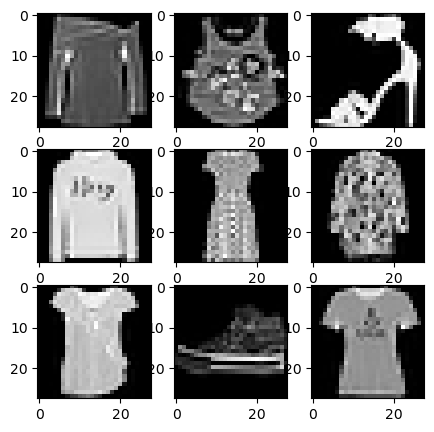

In [118]:
figure = plt.figure(figsize=(5,5))
col, row = 3, 3

for i in range(1, col*row + 1):
    sample_ix = torch.randint(len(train_data), size=(1,)).item()
    figure.add_subplot(row, col, i)
    plt.imshow(train_data[sample_ix][0].squeeze(), cmap='gray')
    print(train_data[sample_ix][0].shape)

# Preparing your data for training with DataLoaders

In [119]:
train_dataloader = DataLoader(dataset=train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=64, shuffle=True)

# Creating the Model

In [120]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.all_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
    
    def forward(self, x):
        x = self.all_layers(x)
        return x

# Making Model Instance

In [121]:
model = NeuralNetwork().to(device)

# Making Training & Testing Loops

In [133]:
def train(dataloader, model, loss_fn, optimizer):

    model.train()

    for batch, (X, y) in enumerate(dataloader):

        sz = len(dataloader.dataset)
        X, y = X.to(device), y.to(device)

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss, current = loss.item(), (batch + 1)*len(X)

        if batch%100 == 0:
            print(f"Loss: {loss:>.4f} {current}/{sz}")


def test(dataloader, model, loss_fn):

    model.eval()
    test_loss, correct = 0, 0
    num_batches = len(dataloader)
    sz = len(dataloader.dataset)

    with torch.no_grad():

        for batch, (X, y) in enumerate(dataloader):

            
            X, y = X.to(device), y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
            # print(correct)

        print(f"Average Test Loss: {test_loss/num_batches:>4f} | Average Accuracy: {(correct/len(dataloader.dataset))*100:>2f}%")





# Choosing Model Parameters

In [135]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epoch = 10

In [137]:
for i in range(epoch):
    print(f"\n------------------------------------\nEpoch {i + 1}\n------------------------------------ ")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")


------------------------------------
Epoch 1
------------------------------------ 
Loss: 0.6151 64/60000
Loss: 0.6723 6464/60000
Loss: 0.7242 12864/60000
Loss: 0.5689 19264/60000
Loss: 0.7670 25664/60000
Loss: 0.7982 32064/60000
Loss: 0.6437 38464/60000
Loss: 0.7383 44864/60000
Loss: 0.6869 51264/60000
Loss: 0.4434 57664/60000
Average Test Loss: 0.674191 | Average Accuracy: 75.850000%

------------------------------------
Epoch 2
------------------------------------ 
Loss: 0.7982 64/60000
Loss: 0.6404 6464/60000
Loss: 0.7136 12864/60000
Loss: 0.8322 19264/60000
Loss: 0.5403 25664/60000
Loss: 0.6750 32064/60000
Loss: 0.5875 38464/60000
Loss: 0.6037 44864/60000
Loss: 0.6151 51264/60000
Loss: 0.5115 57664/60000
Average Test Loss: 0.660897 | Average Accuracy: 76.610000%

------------------------------------
Epoch 3
------------------------------------ 
Loss: 0.6206 64/60000
Loss: 0.5897 6464/60000
Loss: 0.6770 12864/60000
Loss: 0.5665 19264/60000
Loss: 0.6255 25664/60000
Loss: 0.6338 3206

# Saving Model Weights

In [138]:
wts = torch.save(model.state_dict(), "fashnionmnist_mdl_wts.pth")

In [139]:
saved_model = torch.save(model, "fashionmnist_mdl.pth")

# Loading Model & Weights

In [140]:
new_model = torch.load("fashionmnist_mdl.pth")

In [141]:
new_model

NeuralNetwork(
  (all_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [148]:
for name, para in model.named_parameters():
    print(f"Name: {name} | size: {para.size()} | parameters: {para[:2]}")

Name: all_layers.1.weight | size: torch.Size([512, 784]) | parameters: tensor([[-0.0241, -0.0282,  0.0092,  ..., -0.0356, -0.0039, -0.0017],
        [-0.0355,  0.0289, -0.0247,  ...,  0.0270, -0.0182,  0.0246]],
       device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.1.bias | size: torch.Size([512]) | parameters: tensor([ 0.0332, -0.0192], device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.3.weight | size: torch.Size([512, 512]) | parameters: tensor([[ 0.0409, -0.0048, -0.0212,  ...,  0.0294,  0.0511, -0.0280],
        [ 0.0128,  0.0335, -0.0181,  ...,  0.0140,  0.0091, -0.0294]],
       device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.3.bias | size: torch.Size([512]) | parameters: tensor([-0.0578,  0.0352], device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.5.weight | size: torch.Size([10, 512]) | parameters: tensor([[-0.0371, -0.0828, -0.0007,  ...,  0.0144, -0.0937,  0.0073],
        [ 0.0582, -0.0372,  0.0560,  ..., -0.0901,  0.0640, -0.1718]],
 

In [153]:
for name, para in new_model.named_parameters():
    print(f"Name: {name} | size: {para.size()} | parameters: {para[:2]}")

Name: all_layers.1.weight | size: torch.Size([512, 784]) | parameters: tensor([[-0.0241, -0.0282,  0.0092,  ..., -0.0356, -0.0039, -0.0017],
        [-0.0355,  0.0289, -0.0247,  ...,  0.0270, -0.0182,  0.0246]],
       device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.1.bias | size: torch.Size([512]) | parameters: tensor([ 0.0332, -0.0192], device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.3.weight | size: torch.Size([512, 512]) | parameters: tensor([[ 0.0409, -0.0048, -0.0212,  ...,  0.0294,  0.0511, -0.0280],
        [ 0.0128,  0.0335, -0.0181,  ...,  0.0140,  0.0091, -0.0294]],
       device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.3.bias | size: torch.Size([512]) | parameters: tensor([-0.0578,  0.0352], device='mps:0', grad_fn=<SliceBackward0>)
Name: all_layers.5.weight | size: torch.Size([10, 512]) | parameters: tensor([[-0.0371, -0.0828, -0.0007,  ...,  0.0144, -0.0937,  0.0073],
        [ 0.0582, -0.0372,  0.0560,  ..., -0.0901,  0.0640, -0.1718]],
 

In [152]:
new_model.load_state_dict(torch.load("fashnionmnist_mdl_wts.pth"))

<All keys matched successfully>